<a href="https://colab.research.google.com/github/shuklasid19/Assignment-2-analyticsmagzine/blob/main/Image_classification_problem_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import os

import keras
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import pickle
import sys
import os

from sklearn.metrics import confusion_matrix , classification_report
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [4]:
#directory where my dataset is stored
import pickle
os.chdir('/content/drive/MyDrive/cifar-10-batches-py')

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


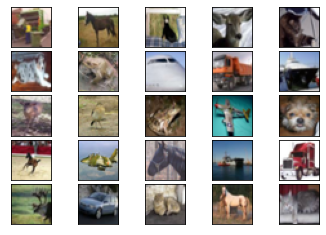

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = '/content/drive/MyDrive/cifar-10-batches-py'

    train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data(cifar_10_dir)

    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    f, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, train_data.shape[0])
            ax[m, n].imshow(train_data[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)
    plt.show()

In [10]:
def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [13]:
def load_data():
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = '/content/drive/MyDrive/cifar-10-batches-py'

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if K.image_data_format() == 'channels_last':
        x_train_local = x_train_local.transpose(0, 2, 3, 1)
        x_test_local = x_test_local.transpose(0, 2, 3, 1)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)

In [14]:
# The data, split between train and test sets:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [15]:
#noramlize the data
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [16]:
from keras.utils import np_utils
num_classes = len(np.unique(y_train))
# Convert class vectors to binary class matrices.
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [17]:
# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [18]:
# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'validation samples')
print(y_test.shape[0], "test samples")

x_train shape: (45000, 32, 32, 3)
45000 train samples
5000 validation samples
10000 test samples


In [19]:
y_train.shape

(45000, 10)

In [20]:
y_test.shape

(10000, 10)

In [21]:
x_test.shape

(10000, 32, 32, 3)

In [22]:
x_train.shape

(45000, 32, 32, 3)

In [23]:
model = Sequential()
model.add(Conv2D(96, (5, 5), padding='same',
                 input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(80, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, (5, 5), padding='same'))
model.add(Activation('relu'))


model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        7296      
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 96)        230496    
                                                                 
 activation_1 (Activation)   (None, 16, 16, 96)        0         
                                                        

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
#i had made previous model and then tried to improve it 

from keras.callbacks import ModelCheckpoint   

# train the model
# callbacks=[checkpointer], 
#checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid),
          verbose=2, shuffle=True)

Epoch 1/10
1407/1407 - 35s - loss: 1.8852 - accuracy: 0.3115 - val_loss: 1.5947 - val_accuracy: 0.4316 - 35s/epoch - 25ms/step
Epoch 2/10
1407/1407 - 33s - loss: 1.4856 - accuracy: 0.4759 - val_loss: 1.3882 - val_accuracy: 0.5166 - 33s/epoch - 23ms/step
Epoch 3/10
1407/1407 - 33s - loss: 1.3563 - accuracy: 0.5308 - val_loss: 1.4559 - val_accuracy: 0.4938 - 33s/epoch - 23ms/step
Epoch 4/10
1407/1407 - 32s - loss: 1.2922 - accuracy: 0.5590 - val_loss: 1.2459 - val_accuracy: 0.5830 - 32s/epoch - 23ms/step
Epoch 5/10
1407/1407 - 32s - loss: 1.2407 - accuracy: 0.5799 - val_loss: 1.2559 - val_accuracy: 0.6048 - 32s/epoch - 23ms/step
Epoch 6/10
1407/1407 - 32s - loss: 1.2094 - accuracy: 0.5932 - val_loss: 1.5480 - val_accuracy: 0.5858 - 32s/epoch - 23ms/step
Epoch 7/10
1407/1407 - 32s - loss: 1.2035 - accuracy: 0.5979 - val_loss: 1.1695 - val_accuracy: 0.6258 - 32s/epoch - 23ms/step
Epoch 8/10
1407/1407 - 32s - loss: 1.3240 - accuracy: 0.6002 - val_loss: 1.2226 - val_accuracy: 0.6114 - 32s/ep

In [28]:
df1 = pd.DataFrame(hist.history)
df1_arr = np.array(df1)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]

In [29]:
val_accuracy

0.6425999999046326

In [30]:

model1_info = {'Architectur': 1 , 
          'kernel_size': (5,5) , 
          'padding': 'same', 
          'activation': 'relu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'rmsprop',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }
          

In [31]:
model1_info

{'Architectur': 1,
 'Subsampling': True,
 'accuracy': 0.5964444279670715,
 'activation': 'relu',
 'dropout': True,
 'epochs': 10,
 'kernel_size': (5, 5),
 'loss': 1.247938632965088,
 'optimizer': 'rmsprop',
 'padding': 'same',
 'stride': 1,
 'val_accuracy': 0.6425999999046326,
 'val_loss': 1.0344123840332031}

In [32]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

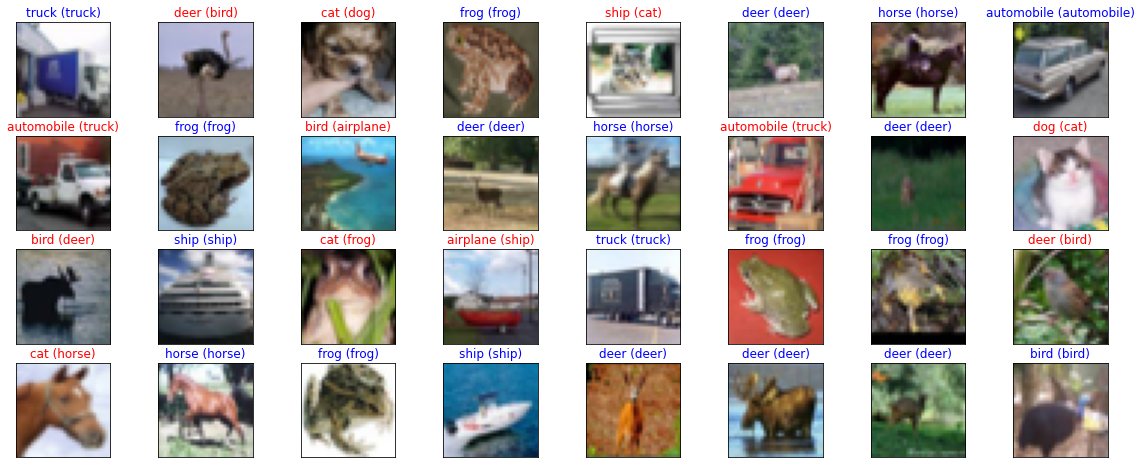

In [33]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [34]:
y_pred = model.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [35]:
y_test_class = np.argmax(y_test, axis=1)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1000
           1       0.83      0.80      0.82      1000
           2       0.57      0.41      0.48      1000
           3       0.45      0.40      0.42      1000
           4       0.39      0.79      0.53      1000
           5       0.63      0.39      0.49      1000
           6       0.68      0.75      0.71      1000
           7       0.82      0.63      0.71      1000
           8       0.76      0.82      0.79      1000
           9       0.87      0.68      0.76      1000

    accuracy                           0.64     10000
   macro avg       0.67      0.64      0.64     10000
weighted avg       0.67      0.64      0.64     10000



In [37]:
print(confusion_matrix(y_test_class, classes_x))

[[722  14  57  11  92   1  12   5  76  10]
 [ 28 802   7   7  15   3  30   2  44  62]
 [ 61   2 415  44 354  34  56  15  17   2]
 [ 18   3  84 398 188 124 120  17  36  12]
 [ 31   0  28  34 788  17  46  44  12   0]
 [ 12   2  70 244 163 394  57  39  19   0]
 [  4   3  15  52 157   1 747   1  18   2]
 [ 14   0  29  50 214  47   7 634   1   4]
 [105  18  13  13   9   1   6   1 825   9]
 [ 68 119  13  23  16   2  22  18  38 681]]


In [42]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=(12, 8))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize=(12, 8))
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

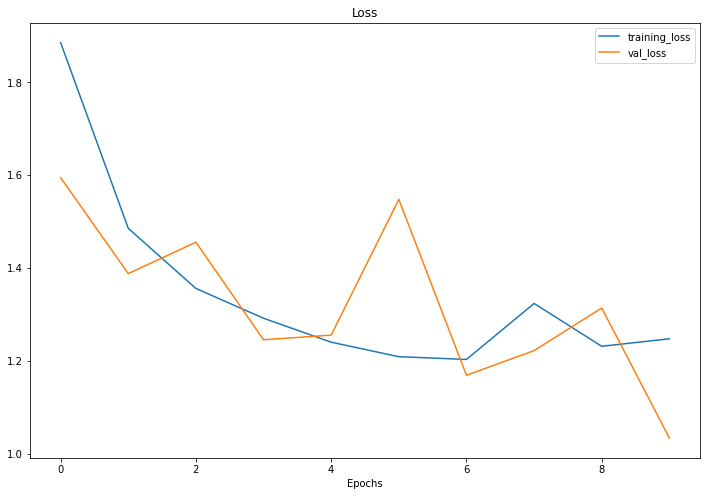

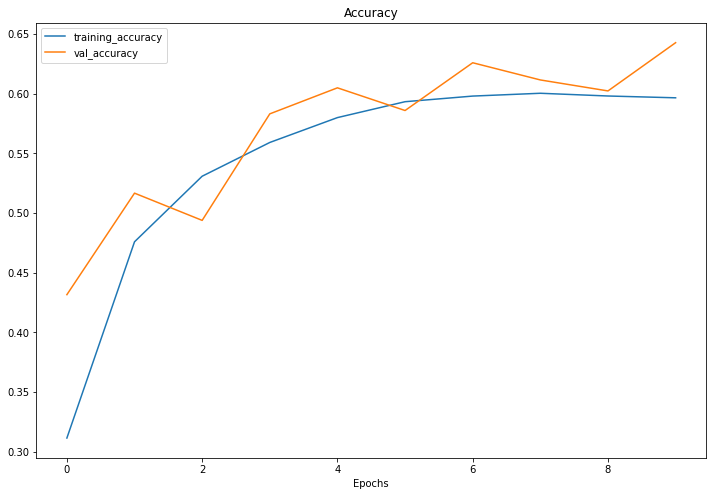

In [43]:
plot_loss_curves(hist)

CNN-2


In [116]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


model2 = Sequential()
model2.add(Conv2D(filters=96, kernel_size=(3,3), padding='valid', activation='elu', 
                        input_shape=(32, 32, 3))) 
model2.add(MaxPooling2D(pool_size=(2, 2))) 

model2.add(Conv2D(filters=96, kernel_size=(3,3), padding='valid', activation='elu')) 

model2.add(MaxPooling2D(pool_size=(2,2))) 

model2.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='elu')) #4,4,256

model2.add(Flatten())

model2.add(Dense(500, activation='elu'))

model2.add(Dropout(0.3))

model2.add(Dense(10, activation='softmax'))

model2.summary()

opt = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Compiling
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
history_2 = model2.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)


# logging info
df2 = pd.DataFrame(history_2.history)
df2_arr = np.array(df2)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]

model2_info = {'Architectur': 2, 
          'kernel_size': (3,3) , 
          'padding': 'valid', 
          'activation': 'elu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'Adamax',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 15, 15, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 13, 13, 96)        83040     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 6, 6, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 4, 4, 256)         221440    
                                                                 
 flatten_7 (Flatten)         (None, 4096)            

In [47]:
# get predictions on the test set
y_hat = model2.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

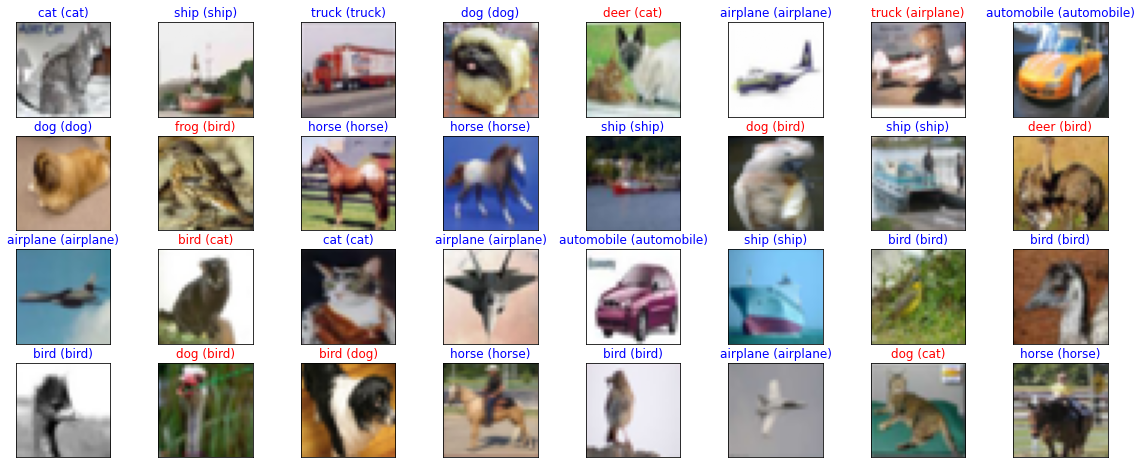

In [48]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

Red images are miss classified ones and red ones are ground truth = predicted label. 

In [49]:
y_pred = model2.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1000
           1       0.82      0.86      0.84      1000
           2       0.63      0.66      0.65      1000
           3       0.57      0.56      0.56      1000
           4       0.66      0.75      0.70      1000
           5       0.67      0.57      0.62      1000
           6       0.87      0.73      0.79      1000
           7       0.76      0.76      0.76      1000
           8       0.81      0.84      0.82      1000
           9       0.83      0.78      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



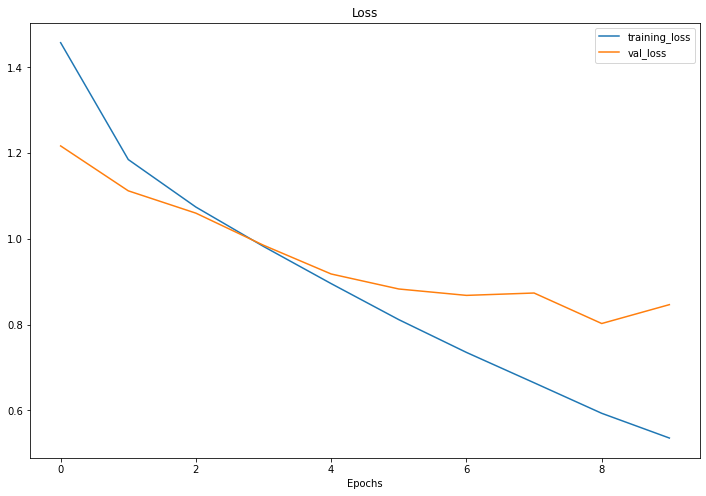

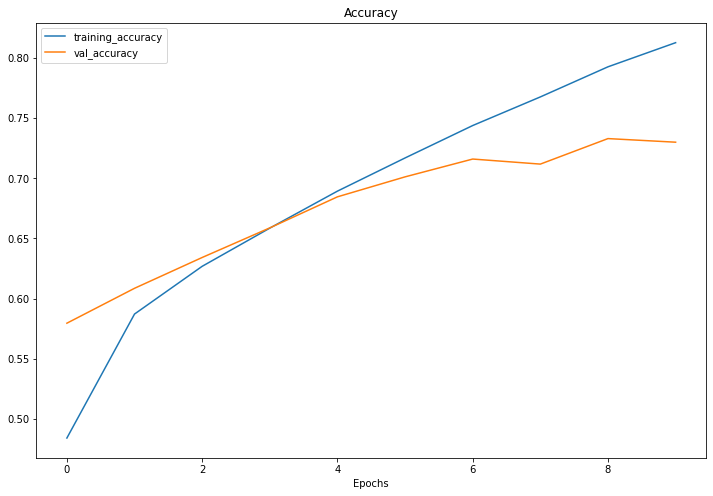

In [51]:
# Check out the loss curves of model_4
plot_loss_curves(history_2)

In [52]:
confusion_matrix(y_test_class, classes_x)

array([[799,  27,  31,  14,  18,   1,   6,   8,  59,  37],
       [ 20, 856,  12,   8,   3,   3,   8,  11,  19,  60],
       [ 76,   6, 664,  55,  79,  43,  25,  32,  17,   3],
       [ 32,  12,  74, 560,  76, 134,  27,  51,  20,  14],
       [ 23,   1,  53,  64, 747,  28,  22,  43,  17,   2],
       [ 25,   5,  78, 175,  51, 575,  14,  59,  12,   6],
       [ 20,   6,  77,  63,  58,  23, 732,   9,  10,   2],
       [ 20,   4,  42,  30,  84,  44,   2, 757,  10,   7],
       [ 54,  41,  10,   8,   7,   3,   4,   5, 837,  31],
       [ 36,  85,  13,  14,  10,   5,   4,  17,  38, 778]])

It works better then the previous model so we can say that if we increase number of layers and epochs the model will give much better accuracy

CNN-3

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


model3 = Sequential()
model3.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='relu', 
                        input_shape=(32, 32, 3))) 
model3.add(MaxPooling2D(pool_size=(2, 2))) 

model3.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='relu')) 

model3.add(MaxPooling2D(pool_size=(2,2))) 

model3.add(Conv2D(filters=80, kernel_size=(3,3), padding='same', activation='relu')) 
model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')) 
model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')) 
model3.add(Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu')) 

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))

model3.add(Dropout(0.3))

model3.add(Dense(10, activation='softmax'))

model3.summary()

opt = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Compiling
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
history_3 = model3.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)


# logging info
df3 = pd.DataFrame(history_3.history)
df3_arr = np.array(df3)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 96)        7296      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 96)        230496    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 96)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 80)          69200     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 64)         

In [115]:
model3_info = {'Architectur': 3, 
          'kernel_size': (5,5) , 
          'padding': 'same', 
          'activation': 'relu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'Adamax',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }

In [54]:
# get predictions on the test set
y_hat = model3.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

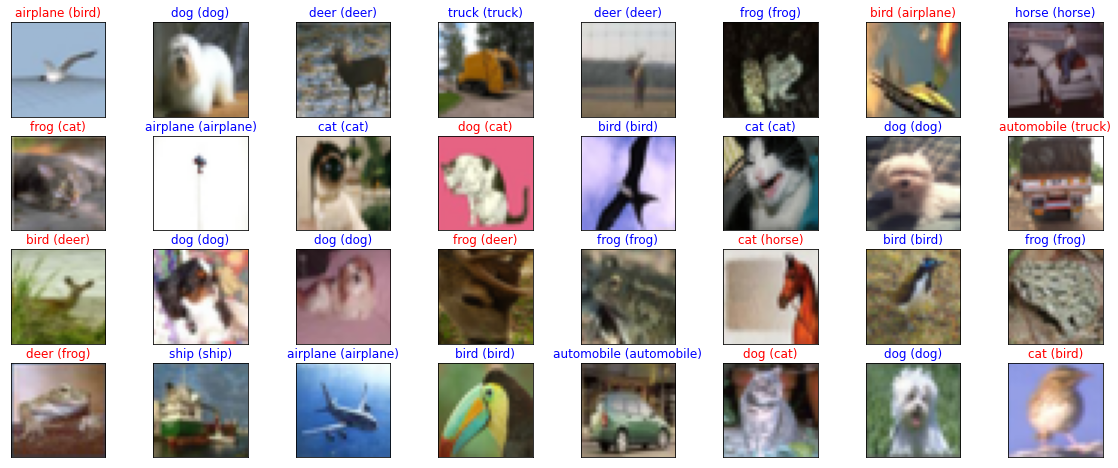

In [55]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [57]:
y_pred = model3.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       0.92      0.80      0.85      1000
           2       0.74      0.54      0.62      1000
           3       0.57      0.55      0.56      1000
           4       0.69      0.69      0.69      1000
           5       0.69      0.63      0.66      1000
           6       0.63      0.92      0.75      1000
           7       0.84      0.79      0.82      1000
           8       0.86      0.88      0.87      1000
           9       0.77      0.89      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [60]:
print(confusion_matrix(y_test_class, classes_x))

[[764  11  27  34  24   3  17  14  63  43]
 [  8 799   6   3   6   0  23   2  25 128]
 [ 64   3 537  74  73  66 130  26  11  16]
 [ 12   8  45 546  66 127 133  25  15  23]
 [ 11   2  44  52 687  24 129  39   8   4]
 [  5   2  28 169  46 631  66  34   7  12]
 [  1   1  14  25  13  12 924   2   5   3]
 [  5   1  17  39  66  44  18 793   3  14]
 [ 44  10   3   6  10   6  17   2 875  27]
 [ 19  33   3  14   3   6  12   6  11 893]]


# CNN-4 Model

In [70]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='elu', 
                        input_shape=(32, 32, 3))) # 30,30,32
model4.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='elu')) # 28,28,64
model4.add(MaxPooling2D(pool_size=2)) # 14,14,64
model4.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='elu')) # 12,12,128
model4.add(MaxPooling2D(pool_size=2)) # 6,6,128
model4.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='elu')) #4,4,256
model4.add(Flatten())
model4.add(Dense(500, activation='elu'))
model4.add(Dropout(0.3))
model4.add(Dense(10, activation='softmax'))
model4.summary()

opt = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Compiling
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
history_4 = model4.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)


# logging info
df4 = pd.DataFrame(history_4.history)
df4_arr = np.array(df4)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]

model4_info = {'Architectur': 4, 
          'kernel_size': (3,3) , 
          'padding': 'valid', 
          'activation': 'elu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'Adamax',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_49 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 4, 4, 256)       

In [71]:
# get predictions on the test set
y_hat = model4.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

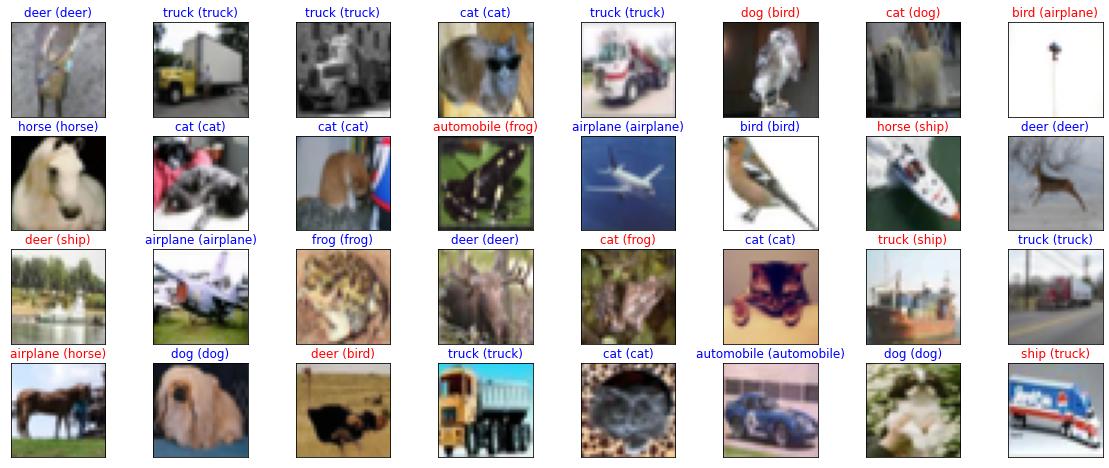

In [72]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [73]:
y_pred = model4.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1000
           1       0.85      0.86      0.85      1000
           2       0.62      0.64      0.63      1000
           3       0.53      0.53      0.53      1000
           4       0.68      0.73      0.71      1000
           5       0.63      0.64      0.64      1000
           6       0.79      0.82      0.81      1000
           7       0.81      0.76      0.79      1000
           8       0.82      0.84      0.83      1000
           9       0.81      0.84      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [75]:
print(confusion_matrix(y_test_class, classes_x))

[[698  21  70  45  26   5   6  12  71  46]
 [ 15 857   4   9   5   1   5   3  31  70]
 [ 34   5 637  76  86  54  44  37  14  13]
 [ 14  10  74 530  58 194  60  31  15  14]
 [  7   4  72  58 732  29  50  37   9   2]
 [  5   5  67 157  44 644  27  41   4   6]
 [  2   5  53  48  33  28 823   2   6   0]
 [  8   4  27  42  73  59   9 764   4  10]
 [ 33  29  17  22   7   8   7   4 837  36]
 [ 15  71   6  12   6   5   8  11  27 839]]


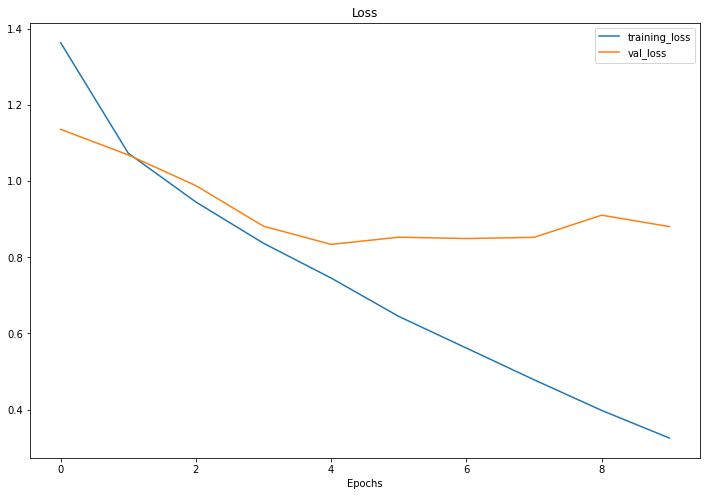

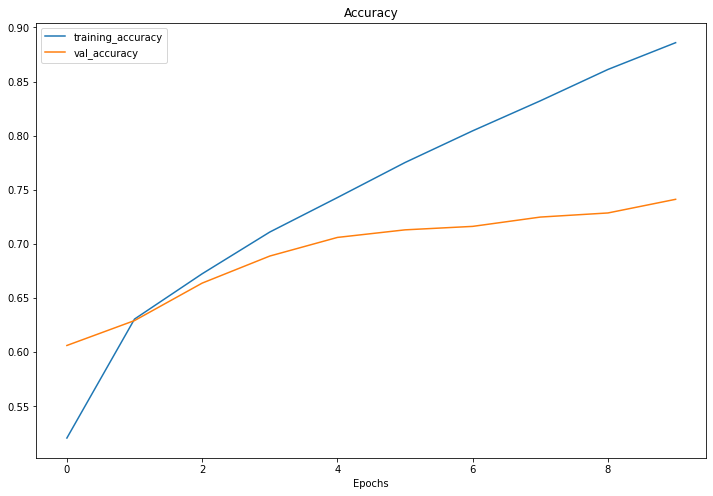

In [78]:
plot_loss_curves(history_4)

CNN-5

In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


model5 = Sequential()
model5.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='selu', 
                        input_shape=(32, 32, 3)))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='selu')) #
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(filters=80, kernel_size=(5,5), padding='same', activation='selu')) #4,4,256

model5.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='selu')) #4,4,256

model5.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='selu')) #4,4,256

model5.add(Conv2D(filters=96, kernel_size=(5,5), padding='same', activation='selu')) #4,4,256

model5.add(Flatten())
model5.add(Dense(256, activation='selu'))
model5.add(Dropout(0.5))
model5.add(Dense(10, activation='softmax'))
model5.summary()

opt = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Compiling
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
history_5 = model4.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)


# logging info
df5 = pd.DataFrame(history_5.history)
df5_arr = np.array(df5)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]

model5_info = {'Architectur': 5, 
          'kernel_size': (5,5) , 
          'padding': 'valid', 
          'activation': 'selu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'Adamax',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 32, 32, 96)        7296      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 16, 16, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 96)        230496    
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 8, 8, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 8, 8, 80)          192080    
                                                                 
 conv2d_84 (Conv2D)          (None, 8, 8, 64)        

In [90]:
# get predictions on the test set
y_hat = model5.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

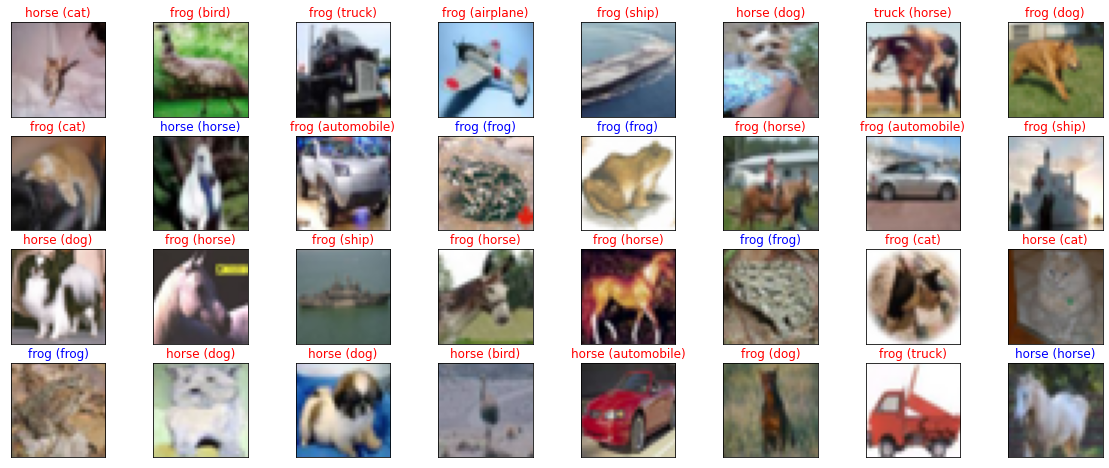

In [91]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [92]:
y_pred = model5.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.13      0.05      0.07      1000
           1       0.00      0.00      0.00      1000
           2       0.05      0.00      0.00      1000
           3       0.67      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.17      0.00      0.00      1000
           6       0.09      0.62      0.16      1000
           7       0.08      0.19      0.11      1000
           8       0.00      0.00      0.00      1000
           9       0.12      0.04      0.06      1000

    accuracy                           0.09     10000
   macro avg       0.13      0.09      0.04     10000
weighted avg       0.13      0.09      0.04     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
print(confusion_matrix(y_test_class, classes_x))

[[ 52   0   2   0   0   0 796 130   0  20]
 [ 54   0   4   1   0   1 769 141  10  20]
 [ 35   0   2   0   0   0 621 298   8  36]
 [ 41   0   9   2   1   0 523 362  10  52]
 [ 13   0   8   0   0   0 553 387  15  24]
 [ 37   0   6   0   0   1 518 378  17  43]
 [ 24   0   0   0   0   0 623 314   8  31]
 [ 34   0   3   0   0   3 698 194  18  50]
 [ 58   0   0   0   1   0 778 148   0  15]
 [ 53   0   3   0   0   1 836  65   3  39]]


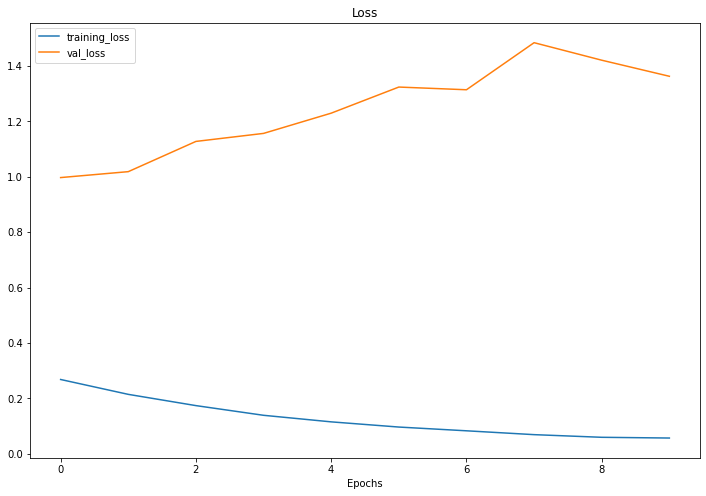

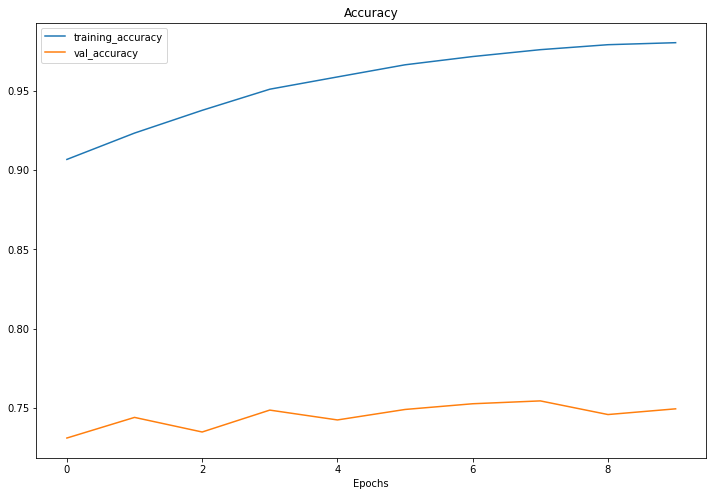

In [108]:
plot_loss_curves(history_5)

In [ ]:
#worst model in all of the models that we made
#if we increase the epoch size the models accuracy certainly increases in every case
#activation function can play a major role for deciding the class
#layer and stride can decide how fast our model will be trained

In [126]:
df = pd.DataFrame([model1_info,model2_info, model3_info , model4_info, model5_info])

In [127]:
df

,Architectur,kernel_size,padding,activation,Subsampling,stride,optimizer,dropout,loss,accuracy,val_loss,val_accuracy,epochs
0,1,"(5, 5)",same,relu,True,1,rmsprop,True,1.247939,0.596444,1.034412,0.6426,10
1,2,"(3, 3)",valid,elu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
2,3,"(5, 5)",same,relu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
3,4,"(3, 3)",valid,elu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
4,5,"(5, 5)",valid,selu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10


In [111]:
m 

({'Architectur': 1,
  'Subsampling': True,
  'accuracy': 0.5964444279670715,
  'activation': 'relu',
  'dropout': True,
  'epochs': 10,
  'kernel_size': (5, 5),
  'loss': 1.247938632965088,
  'optimizer': 'rmsprop',
  'padding': 'same',
  'stride': 1,
  'val_accuracy': 0.6425999999046326,
  'val_loss': 1.0344123840332031},
 {'Architectur': 2,
  'Subsampling': True,
  'accuracy': 0.5964444279670715,
  'activation': 'elu',
  'dropout': True,
  'epochs': 10,
  'kernel_size': (3, 3),
  'loss': 1.247938632965088,
  'optimizer': 'Adamax',
  'padding': 'valid',
  'stride': 1,
  'val_accuracy': 0.6425999999046326,
  'val_loss': 1.0344123840332031})

In [128]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf


model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='elu', 
                        input_shape=(32, 32, 3)))
model6.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='elu')) 
model6.add(MaxPooling2D(pool_size=2))
model6.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='elu')) 
model6.add(MaxPooling2D(pool_size=2)) 
model6.add(Conv2D(filters=256, kernel_size=(3,3), padding='valid', activation='elu'))
model6.add(Flatten())
model6.add(Dense(500, activation='elu'))
model6.add(Dropout(0.3))
model6.add(Dense(10, activation='softmax'))
model6.summary()

opt = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Compiling
model6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model
hist6 = model6.fit(x_train, y_train, batch_size=32, epochs=10,
          validation_data=(x_valid, y_valid), 
          verbose=2, shuffle=True)


# logging info
df6 = pd.DataFrame(hist6.history)
df6_arr = np.array(df6)
final = df1_arr[-1]
loss = final[0]
accuracy = final[1]
val_loss = final[2]
val_accuracy = final[3]

model4 = {'Architectur': 6, 
          'kernel_size': (3,3) , 
          'padding': 'valid', 
          'activation': 'elu', 
          'Subsampling': True,
          'stride': 1,
          'optimizer': 'Adamax',
          'dropout': True,
          'loss': loss,
          'accuracy': accuracy,
          'val_loss' : val_loss,
          'val_accuracy': val_accuracy,
          'epochs': 10
          }

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_91 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 4, 4, 256)       

In [129]:
# get predictions on the test set
y_hat = model6.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

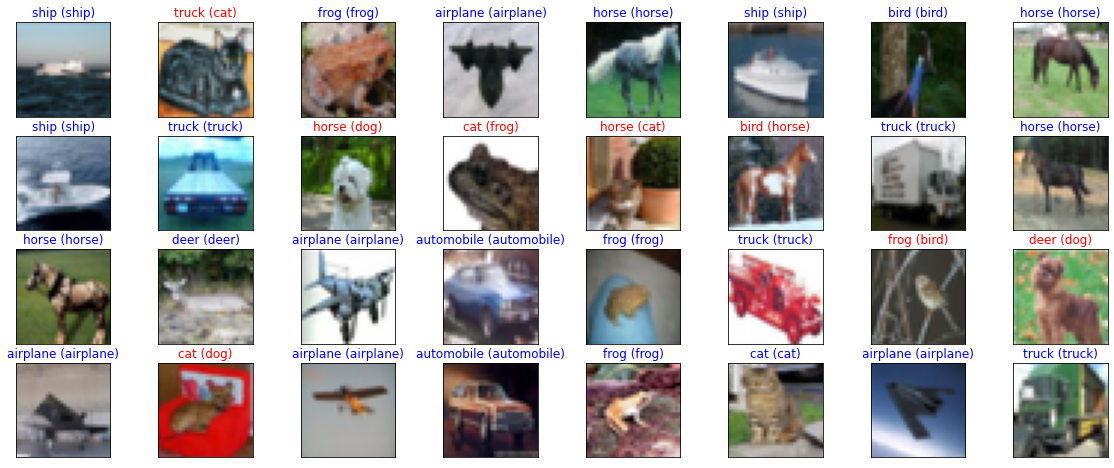

In [130]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [132]:
y_pred = model6.predict(x_test)
classes_x = np.argmax(y_pred, axis=1)

In [133]:
print(confusion_matrix(y_test_class, classes_x))

[[776  18  17  15  12   4   9   7  80  62]
 [ 14 831   8   9   1   8   6   0  33  90]
 [ 90   4 592  62  64  80  46  28  22  12]
 [ 39  12  59 490  44 227  43  31  30  25]
 [ 26   6  77  75 636  66  40  46  24   4]
 [ 27   4  36 123  24 700  25  36  11  14]
 [ 11   6  58  64  19  30 786   1  18   7]
 [ 25   5  33  26  43  87   7 732  10  32]
 [ 43  28   8   6   1   4   7   2 861  40]
 [ 21  55   6   6   4   1   5   5  38 859]]


In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, classes_x))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1000
           1       0.86      0.83      0.84      1000
           2       0.66      0.59      0.63      1000
           3       0.56      0.49      0.52      1000
           4       0.75      0.64      0.69      1000
           5       0.58      0.70      0.63      1000
           6       0.81      0.79      0.80      1000
           7       0.82      0.73      0.78      1000
           8       0.76      0.86      0.81      1000
           9       0.75      0.86      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000



In [138]:
df = pd.DataFrame([model1_info,model2_info, model3_info , model4_info, model5_info, model4])

In [139]:
df

,Architectur,kernel_size,padding,activation,Subsampling,stride,optimizer,dropout,loss,accuracy,val_loss,val_accuracy,epochs
0,1,"(5, 5)",same,relu,True,1,rmsprop,True,1.247939,0.596444,1.034412,0.6426,10
1,2,"(3, 3)",valid,elu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
2,3,"(5, 5)",same,relu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
3,4,"(3, 3)",valid,elu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
4,5,"(5, 5)",valid,selu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
5,6,"(3, 3)",valid,elu,True,1,Adamax,True,1.247939,0.596444,1.034412,0.6426,10
